In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 46.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.31MB/s]


In [2]:

print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA (GPU) available? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Current device index: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. The code will run on your CPU.")

PyTorch version: 2.8.0+cu126
Is CUDA (GPU) available? True
GPU Name: Tesla T4
Current device index: 0


In [3]:
class CNNModel(nn.Module):
    def __init__(self, act_fn, dropout_rate=0.25, use_bn=False):
        super(CNNModel, self).__init__()
        self.act = act_fn
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        return self.fc2(x)

class MLPModel(nn.Module):
    def __init__(self, act_fn, use_bn=True, dropout_rate=0.0):
        super(MLPModel, self).__init__()
        # Fix: Convert function pointers to Modules for nn.Sequential
        if act_fn == torch.relu: act_module = nn.ReLU()
        elif act_fn == torch.sigmoid: act_module = nn.Sigmoid()
        elif act_fn == torch.tanh: act_module = nn.Tanh()
        else: act_module = act_fn 

        layers = [nn.Flatten()]
        layers.append(nn.Linear(784, 256))
        if use_bn: layers.append(nn.BatchNorm1d(256))
        layers.append(act_module)
        
        layers.append(nn.Linear(256, 128))
        if use_bn: layers.append(nn.BatchNorm1d(128))
        layers.append(act_module)
        
        if dropout_rate > 0: layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(128, 10))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [4]:
def plot_task_results(histories, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for name, hist in histories.items():
        # Plot Test with a solid line
        plt.plot(hist['test_acc'], label=f'{name} Test (Solid)')
        # Plot Train with a dashed line and a label
        plt.plot(hist['train_acc'], linestyle='--', label=f'{name} Train (Dash)', alpha=0.7)
        
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside so it's not messy

    # Loss Plot
    plt.subplot(1, 2, 2)
    for name, hist in histories.items():
        plt.plot(hist['train_loss'], label=f'{name} Loss')
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
all_results_data = []

def run_experiment(model_class, act_fn, opt_type, use_bn=False, dropout=0.0, epochs=10, label="Exp"):
    model = model_class(act_fn, dropout_rate=dropout, use_bn=use_bn).to(device)
    criterion = nn.CrossEntropyLoss()
    
    if opt_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif opt_type == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {
        'train_acc': [], 
        'test_acc': [], 
        'train_loss': [], 
        'test_loss': []
    }

    print(f"\n===== Running {model_class.__name__} [{label}] | Opt: {opt_type} | BN: {use_bn} | Dropout: {dropout} =====")

    for epoch in range(epochs):
        # ---------- TRAIN ----------
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = out.max(1)
            total += lbls.size(0)
            correct += pred.eq(lbls).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # ---------- VALIDATION / TEST ----------
        model.eval()
        t_correct, t_total, t_running_loss = 0, 0, 0.0
        
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                loss = criterion(out, lbls)

                t_running_loss += loss.item()
                _, pred = out.max(1)
                t_total += lbls.size(0)
                t_correct += pred.eq(lbls).sum().item()

        test_loss = t_running_loss / len(test_loader)
        test_acc = 100. * t_correct / t_total

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%")

    all_results_data.append({
        "Model": model_class.__name__,
        "Activation": label,
        "Optimizer": opt_type,
        "BN": use_bn,
        "Dropout": dropout,
        "Accuracy": f"{history['test_acc'][-1]:.2f}%"
    })
    
    del model
    torch.cuda.empty_cache()
    return history

Starting CNN Tasks...

===== Running CNNModel [Sigmoid] | Opt: SGD | BN: False | Dropout: 0.0 =====
Epoch [1/10] | Train Loss: 2.3013, Train Acc: 11.23% | Val Loss: 2.2995, Val Acc: 10.32%
Epoch [2/10] | Train Loss: 2.2982, Train Acc: 11.78% | Val Loss: 2.2962, Val Acc: 11.35%
Epoch [3/10] | Train Loss: 2.2952, Train Acc: 12.34% | Val Loss: 2.2929, Val Acc: 11.35%
Epoch [4/10] | Train Loss: 2.2912, Train Acc: 12.62% | Val Loss: 2.2880, Val Acc: 15.62%
Epoch [5/10] | Train Loss: 2.2851, Train Acc: 14.74% | Val Loss: 2.2801, Val Acc: 25.78%
Epoch [6/10] | Train Loss: 2.2750, Train Acc: 17.35% | Val Loss: 2.2678, Val Acc: 13.15%
Epoch [7/10] | Train Loss: 2.2579, Train Acc: 23.12% | Val Loss: 2.2441, Val Acc: 26.25%
Epoch [8/10] | Train Loss: 2.2244, Train Acc: 34.63% | Val Loss: 2.1979, Val Acc: 33.38%
Epoch [9/10] | Train Loss: 2.1519, Train Acc: 47.72% | Val Loss: 2.0866, Val Acc: 52.44%
Epoch [10/10] | Train Loss: 1.9833, Train Acc: 58.42% | Val Loss: 1.8388, Val Acc: 64.14%

===== Ru

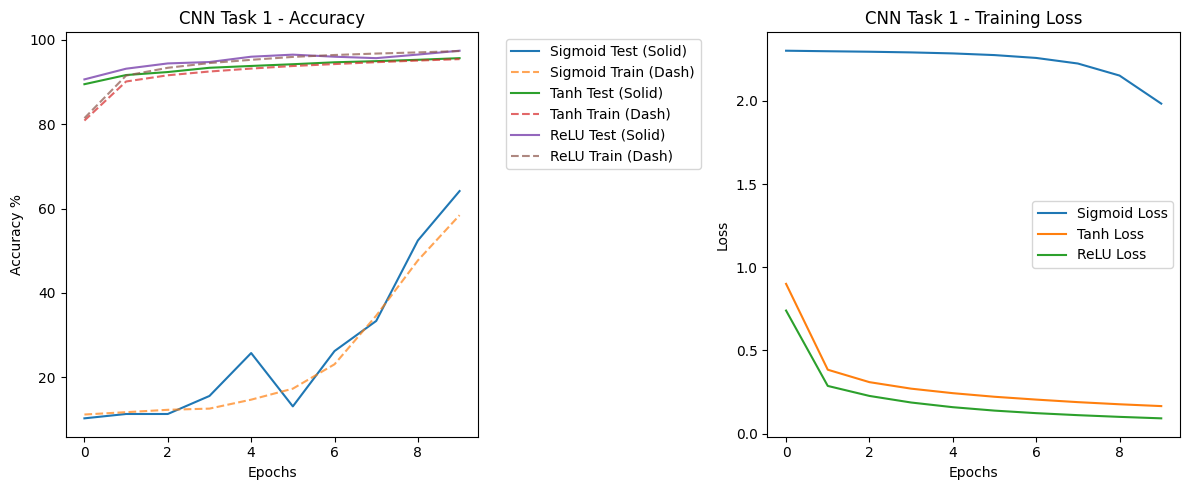

In [6]:
print("Starting CNN Tasks...")
cnn_t1 = {"Sigmoid": run_experiment(CNNModel, torch.sigmoid, "SGD", label="Sigmoid"),
          "Tanh": run_experiment(CNNModel, torch.tanh, "SGD", label="Tanh"),
          "ReLU": run_experiment(CNNModel, torch.relu, "SGD", label="ReLU")}
plot_task_results(cnn_t1, "CNN Task 1")


===== Running CNNModel [ReLU] | Opt: SGD | BN: False | Dropout: 0.0 =====
Epoch [1/10] | Train Loss: 0.7879, Train Acc: 80.84% | Val Loss: 0.3431, Val Acc: 89.97%
Epoch [2/10] | Train Loss: 0.3062, Train Acc: 90.91% | Val Loss: 0.2637, Val Acc: 92.15%
Epoch [3/10] | Train Loss: 0.2453, Train Acc: 92.78% | Val Loss: 0.2137, Val Acc: 93.71%
Epoch [4/10] | Train Loss: 0.2029, Train Acc: 93.96% | Val Loss: 0.1743, Val Acc: 94.85%
Epoch [5/10] | Train Loss: 0.1707, Train Acc: 94.91% | Val Loss: 0.1576, Val Acc: 95.39%
Epoch [6/10] | Train Loss: 0.1475, Train Acc: 95.62% | Val Loss: 0.1349, Val Acc: 95.91%
Epoch [7/10] | Train Loss: 0.1287, Train Acc: 96.22% | Val Loss: 0.1340, Val Acc: 96.15%
Epoch [8/10] | Train Loss: 0.1147, Train Acc: 96.64% | Val Loss: 0.1090, Val Acc: 96.71%
Epoch [9/10] | Train Loss: 0.1039, Train Acc: 96.96% | Val Loss: 0.0946, Val Acc: 97.15%
Epoch [10/10] | Train Loss: 0.0956, Train Acc: 97.17% | Val Loss: 0.0949, Val Acc: 97.02%

===== Running CNNModel [ReLU] | O

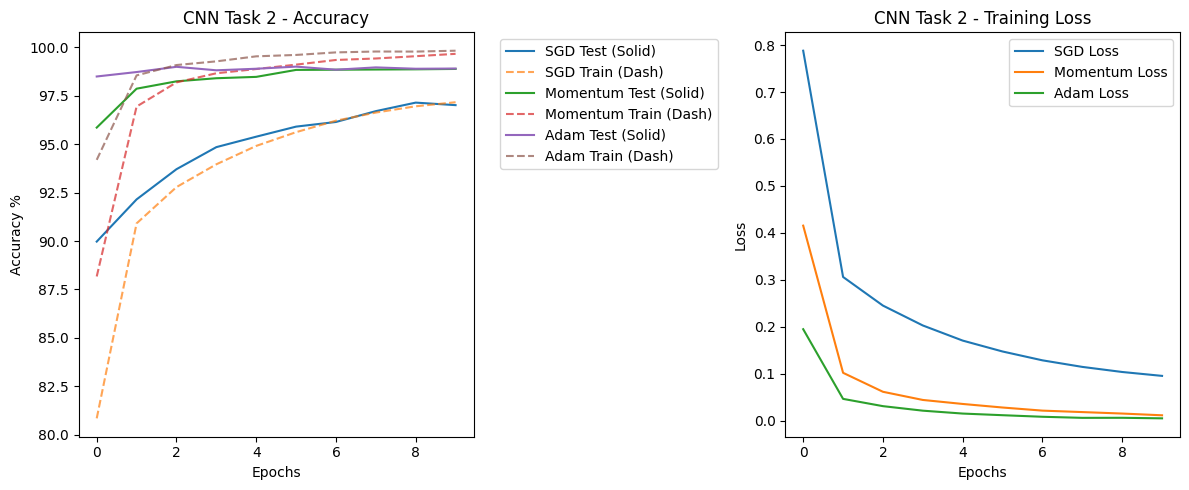

In [7]:
cnn_t2 = {"SGD": run_experiment(CNNModel, torch.relu, "SGD", label="ReLU"),
          "Momentum": run_experiment(CNNModel, torch.relu, "Momentum", label="ReLU"),
          "Adam": run_experiment(CNNModel, torch.relu, "Adam", label="ReLU")}
plot_task_results(cnn_t2, "CNN Task 2")




===== Running CNNModel [ReLU] | Opt: Adam | BN: False | Dropout: 0.0 =====
Epoch [1/10] | Train Loss: 0.1839, Train Acc: 94.45% | Val Loss: 0.0482, Val Acc: 98.37%
Epoch [2/10] | Train Loss: 0.0428, Train Acc: 98.69% | Val Loss: 0.0438, Val Acc: 98.53%
Epoch [3/10] | Train Loss: 0.0282, Train Acc: 99.14% | Val Loss: 0.0449, Val Acc: 98.53%
Epoch [4/10] | Train Loss: 0.0186, Train Acc: 99.39% | Val Loss: 0.0334, Val Acc: 98.98%
Epoch [5/10] | Train Loss: 0.0116, Train Acc: 99.62% | Val Loss: 0.0384, Val Acc: 98.79%
Epoch [6/10] | Train Loss: 0.0102, Train Acc: 99.67% | Val Loss: 0.0358, Val Acc: 98.86%
Epoch [7/10] | Train Loss: 0.0059, Train Acc: 99.80% | Val Loss: 0.0409, Val Acc: 98.91%
Epoch [8/10] | Train Loss: 0.0057, Train Acc: 99.81% | Val Loss: 0.0416, Val Acc: 98.94%
Epoch [9/10] | Train Loss: 0.0050, Train Acc: 99.84% | Val Loss: 0.0470, Val Acc: 98.73%
Epoch [10/10] | Train Loss: 0.0052, Train Acc: 99.85% | Val Loss: 0.0411, Val Acc: 99.02%

===== Running CNNModel [ReLU] | 

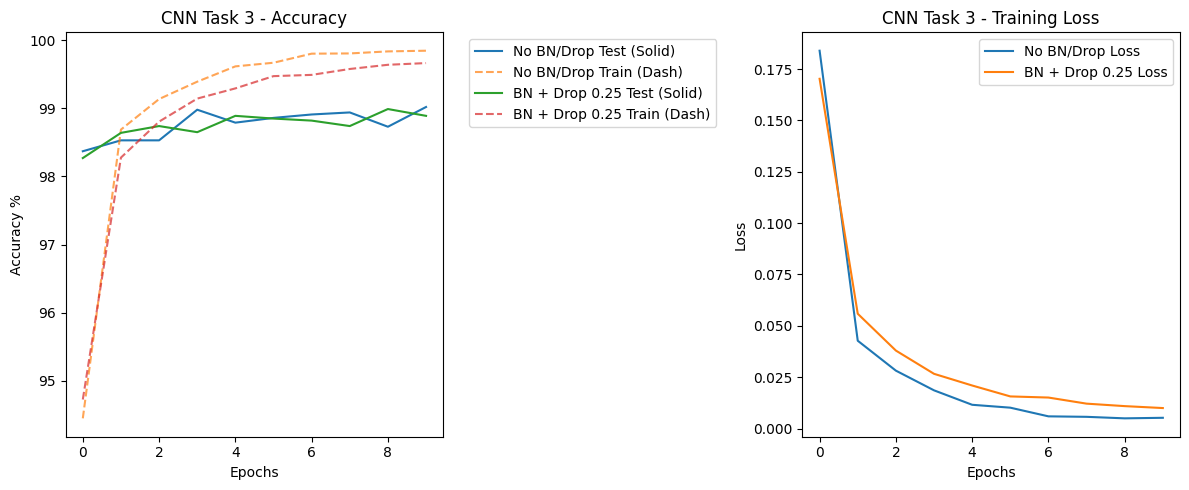

In [8]:
cnn_t3 = {"No BN/Drop": run_experiment(CNNModel, torch.relu, "Adam", use_bn=False, dropout=0.0, label="ReLU"),
          "BN + Drop 0.25": run_experiment(CNNModel, torch.relu, "Adam", use_bn=True, dropout=0.25, label="ReLU")}
plot_task_results(cnn_t3, "CNN Task 3")

Starting MLP Tasks...

===== Running MLPModel [Sigmoid] | Opt: SGD | BN: False | Dropout: 0.0 =====
Epoch [1/10] | Train Loss: 2.2975, Train Acc: 11.35% | Val Loss: 2.2868, Val Acc: 11.35%
Epoch [2/10] | Train Loss: 2.2789, Train Acc: 14.20% | Val Loss: 2.2697, Val Acc: 12.04%
Epoch [3/10] | Train Loss: 2.2599, Train Acc: 20.35% | Val Loss: 2.2470, Val Acc: 30.83%
Epoch [4/10] | Train Loss: 2.2343, Train Acc: 31.19% | Val Loss: 2.2163, Val Acc: 43.18%
Epoch [5/10] | Train Loss: 2.1975, Train Acc: 42.31% | Val Loss: 2.1706, Val Acc: 44.00%
Epoch [6/10] | Train Loss: 2.1416, Train Acc: 47.42% | Val Loss: 2.1006, Val Acc: 46.10%
Epoch [7/10] | Train Loss: 2.0567, Train Acc: 51.37% | Val Loss: 1.9958, Val Acc: 52.97%
Epoch [8/10] | Train Loss: 1.9346, Train Acc: 54.05% | Val Loss: 1.8533, Val Acc: 56.94%
Epoch [9/10] | Train Loss: 1.7801, Train Acc: 57.04% | Val Loss: 1.6873, Val Acc: 58.35%
Epoch [10/10] | Train Loss: 1.6140, Train Acc: 59.91% | Val Loss: 1.5228, Val Acc: 62.91%

===== Ru

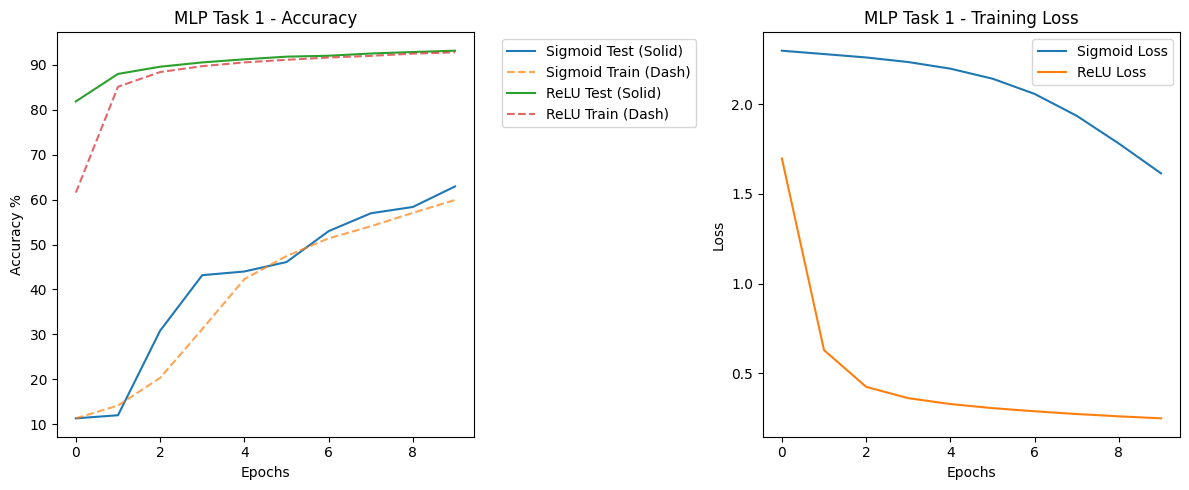

In [9]:
print("Starting MLP Tasks...")
mlp_t1 = {"Sigmoid": run_experiment(MLPModel, torch.sigmoid, "SGD", label="Sigmoid"),
          "ReLU": run_experiment(MLPModel, torch.relu, "SGD", label="ReLU")}
plot_task_results(mlp_t1, "MLP Task 1")



===== Running MLPModel [ReLU] | Opt: SGD | BN: False | Dropout: 0.0 =====
Epoch [1/10] | Train Loss: 1.7766, Train Acc: 57.69% | Val Loss: 0.9611, Val Acc: 81.25%
Epoch [2/10] | Train Loss: 0.6628, Train Acc: 84.48% | Val Loss: 0.4795, Val Acc: 87.57%
Epoch [3/10] | Train Loss: 0.4387, Train Acc: 88.27% | Val Loss: 0.3813, Val Acc: 89.36%
Epoch [4/10] | Train Loss: 0.3720, Train Acc: 89.59% | Val Loss: 0.3377, Val Acc: 90.30%
Epoch [5/10] | Train Loss: 0.3365, Train Acc: 90.34% | Val Loss: 0.3125, Val Acc: 90.86%
Epoch [6/10] | Train Loss: 0.3127, Train Acc: 91.00% | Val Loss: 0.2918, Val Acc: 91.62%
Epoch [7/10] | Train Loss: 0.2945, Train Acc: 91.51% | Val Loss: 0.2772, Val Acc: 92.15%
Epoch [8/10] | Train Loss: 0.2786, Train Acc: 91.93% | Val Loss: 0.2649, Val Acc: 92.37%
Epoch [9/10] | Train Loss: 0.2650, Train Acc: 92.27% | Val Loss: 0.2514, Val Acc: 92.85%
Epoch [10/10] | Train Loss: 0.2534, Train Acc: 92.65% | Val Loss: 0.2415, Val Acc: 93.11%

===== Running MLPModel [ReLU] | O

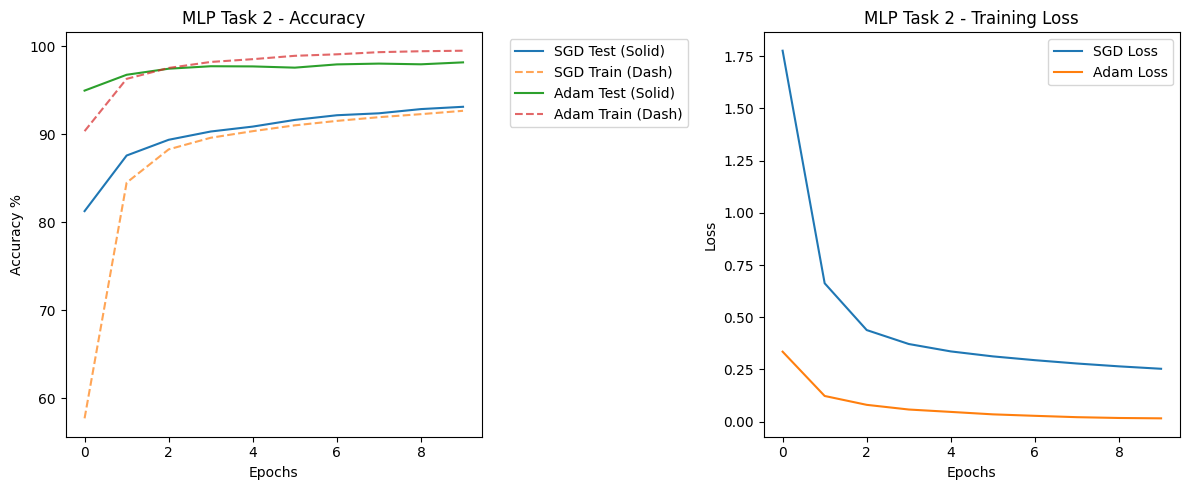

In [10]:
mlp_t2 = {"SGD": run_experiment(MLPModel, torch.relu, "SGD", label="ReLU"),
          "Adam": run_experiment(MLPModel, torch.relu, "Adam", label="ReLU")}
plot_task_results(mlp_t2, "MLP Task 2")


===== Running MLPModel [ReLU] | Opt: Adam | BN: False | Dropout: 0.0 =====
Epoch [1/10] | Train Loss: 0.3351, Train Acc: 90.43% | Val Loss: 0.1541, Val Acc: 95.32%
Epoch [2/10] | Train Loss: 0.1273, Train Acc: 96.11% | Val Loss: 0.1034, Val Acc: 96.70%
Epoch [3/10] | Train Loss: 0.0835, Train Acc: 97.45% | Val Loss: 0.0831, Val Acc: 97.44%
Epoch [4/10] | Train Loss: 0.0615, Train Acc: 98.08% | Val Loss: 0.0753, Val Acc: 97.62%
Epoch [5/10] | Train Loss: 0.0458, Train Acc: 98.59% | Val Loss: 0.0761, Val Acc: 97.81%
Epoch [6/10] | Train Loss: 0.0375, Train Acc: 98.77% | Val Loss: 0.0752, Val Acc: 97.74%
Epoch [7/10] | Train Loss: 0.0299, Train Acc: 99.04% | Val Loss: 0.0743, Val Acc: 97.88%
Epoch [8/10] | Train Loss: 0.0231, Train Acc: 99.29% | Val Loss: 0.0842, Val Acc: 97.54%
Epoch [9/10] | Train Loss: 0.0195, Train Acc: 99.41% | Val Loss: 0.0710, Val Acc: 97.85%
Epoch [10/10] | Train Loss: 0.0142, Train Acc: 99.54% | Val Loss: 0.0917, Val Acc: 97.63%

===== Running MLPModel [ReLU] | 

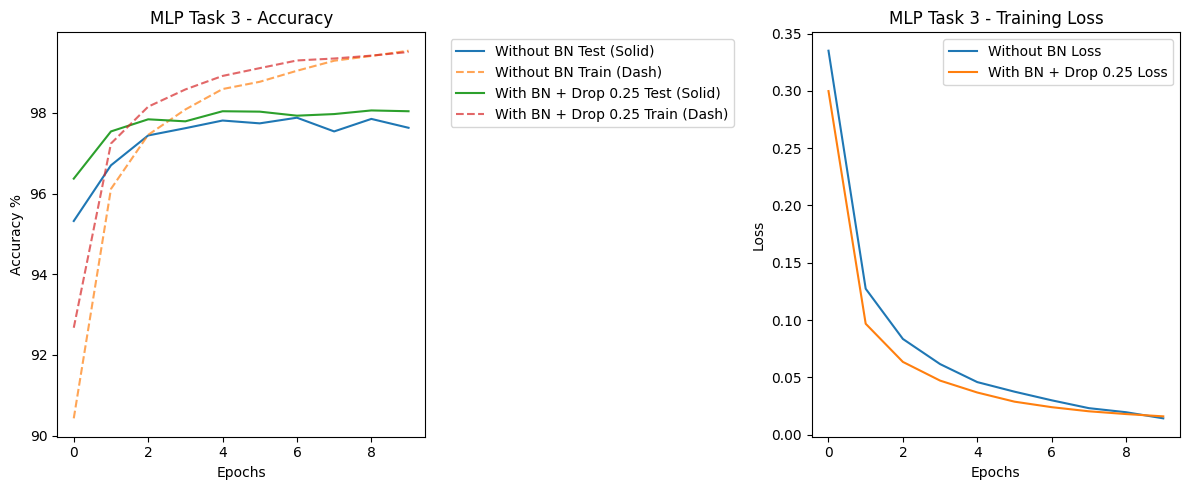

In [11]:
mlp_t3 = {"Without BN": run_experiment(MLPModel, torch.relu, "Adam", use_bn=False, label="ReLU"),
          "With BN + Drop 0.25": run_experiment(MLPModel, torch.relu, "Adam", use_bn=True, dropout=0.25, label="ReLU")}
plot_task_results(mlp_t3, "MLP Task 3")

In [12]:

# Final Table
print("\n" + "="*30 + "\nFINAL RESULTS TABLE\n" + "="*30)
print(pd.DataFrame(all_results_data))


FINAL RESULTS TABLE
       Model Activation Optimizer     BN  Dropout Accuracy
0   CNNModel    Sigmoid       SGD  False     0.00   64.14%
1   CNNModel       Tanh       SGD  False     0.00   95.61%
2   CNNModel       ReLU       SGD  False     0.00   97.37%
3   CNNModel       ReLU       SGD  False     0.00   97.02%
4   CNNModel       ReLU  Momentum  False     0.00   98.89%
5   CNNModel       ReLU      Adam  False     0.00   98.91%
6   CNNModel       ReLU      Adam  False     0.00   99.02%
7   CNNModel       ReLU      Adam   True     0.25   98.89%
8   MLPModel    Sigmoid       SGD  False     0.00   62.91%
9   MLPModel       ReLU       SGD  False     0.00   93.09%
10  MLPModel       ReLU       SGD  False     0.00   93.11%
11  MLPModel       ReLU      Adam  False     0.00   98.16%
12  MLPModel       ReLU      Adam  False     0.00   97.63%
13  MLPModel       ReLU      Adam   True     0.25   98.04%


In [13]:
!pip install torchsummary
from torchsummary import summary

# CNN Architecture
cnn_model = CNNModel(torch.relu).to(device)
print("\n===== CNN MODEL ARCHITECTURE =====")
summary(cnn_model, (1, 28, 28))

# MLP Architecture
mlp_model = MLPModel(torch.relu).to(device)
print("\n===== MLP MODEL ARCHITECTURE =====")
summary(mlp_model, (1, 28, 28))


===== CNN MODEL ARCHITECTURE =====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
          Identity-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
          Identity-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
           Dropout-6           [-1, 64, 12, 12]               0
            Linear-7                  [-1, 128]       1,179,776
            Linear-8                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.03
Params size (MB): 4.58
Estimated Total Size (MB): 5.61
----------------------------------------------------------------

=